# Stock Market Prediction using Numerical and Textual Analysis

In [2]:
# importing libraries
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
nltk.download('vader_lexicon')
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\SAINIKHIL\AppData\Roaming\nltk_data...


In [3]:
 # reading the datasets into pandas
stock_price = pd.read_csv('PLTR.csv')

In [4]:
stock_headlines = pd.read_csv('india-news-headlines.csv')

In [5]:
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-11-09,14.96,15.900000,14.11,14.67,14.67,60099000
1,2020-11-10,14.99,15.010000,13.18,14.00,14.00,38078700
2,2020-11-11,14.57,15.970000,14.40,15.96,15.96,47027900
3,2020-11-12,16.66,17.059999,14.41,14.58,14.58,97904000
4,2020-11-13,14.49,16.000000,14.49,15.80,15.80,76354800


In [6]:
len(stock_price), len(stock_headlines)

(253, 3424067)

In [7]:
stock_price.isna().sum(), stock_headlines.isna().sum()

(Date         0
 Open         0
 High         0
 Low          0
 Close        0
 Adj Close    0
 Volume       0
 dtype: int64,
 publish_date         0
 headline_category    0
 headline_text        0
 dtype: int64)

In [8]:
# dropping duplicates in data
stock_price = stock_price.drop_duplicates()

# converting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to Date
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2020-11-09,14.670000,14.960000,15.900000,14.110000,60099000
2020-11-10,14.000000,14.990000,15.010000,13.180000,38078700
2020-11-11,15.960000,14.570000,15.970000,14.400000,47027900
2020-11-12,14.580000,16.660000,17.059999,14.410000,97904000
2020-11-13,15.800000,14.490000,16.000000,14.490000,76354800
...,...,...,...,...,...
2021-11-03,26.120001,25.889999,26.235001,25.170000,25244200
2021-11-04,26.469999,26.260000,26.570000,25.870001,25029700
2021-11-05,26.000000,26.450001,26.629999,25.719999,25929900


In [9]:
#stock headings
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns 
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to Date
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting Date as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the Date
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


In [10]:
# concatenation of the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2020-11-09,14.670000,14.960000,15.900000,14.110000,60099000.0,"Shettar for furniture cluster in Udupi,Gujarat..."
2020-11-10,14.000000,14.990000,15.010000,13.180000,38078700.0,"'Save Navsari Palace' campaign launched,Horosc..."
2020-11-11,15.960000,14.570000,15.970000,14.400000,47027900.0,Horoscope Today; 11 November 2020: Check astro...
2020-11-12,14.580000,16.660000,17.059999,14.410000,97904000.0,Horoscope Today; 12 November 2020: Check astro...
2020-11-13,15.800000,14.490000,16.000000,14.490000,76354800.0,"Baglamukhi's female aide held,Horoscope Today;..."
2020-11-16,15.930000,15.960000,16.100000,15.010000,65326000.0,Horoscope Today; 16 November 2020: Check astro...
2020-11-17,17.850000,16.290001,18.750000,16.180000,116618500.0,Ganga mela goes green with 'patera' grass mats...
2020-11-18,17.900000,18.280001,19.250000,17.540001,89957900.0,Types 2 diabetes: What to eat and what to avoi...
2020-11-19,18.980000,18.500000,18.980000,17.959999,56225400.0,6 employees share what made them quit their jo...
2020-11-20,18.150000,19.030001,19.660000,18.000000,72104000.0,Cop seeks Rs 15K from IPL betting accused; hel...


In [11]:
#Sentiment Analysis
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2020-11-09,14.67,14.96,15.900000,14.11,60099000.0,"Shettar for furniture cluster in Udupi,Gujarat...",,,,
2020-11-10,14.00,14.99,15.010000,13.18,38078700.0,"'Save Navsari Palace' campaign launched,Horosc...",,,,
2020-11-11,15.96,14.57,15.970000,14.40,47027900.0,Horoscope Today; 11 November 2020: Check astro...,,,,
2020-11-12,14.58,16.66,17.059999,14.41,97904000.0,Horoscope Today; 12 November 2020: Check astro...,,,,
2020-11-13,15.80,14.49,16.000000,14.49,76354800.0,"Baglamukhi's female aide held,Horoscope Today;...",,,,


In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

#Sentiment Analyzer
sid = SentimentIntensityAnalyzer()
print('Start calculating sentiment scores:')

stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
print('Compound Done')
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
print('Negative Done')
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
print('Neutral Done')
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])
print('Positive Done')
print('Stop')

stock_data.head()

Start calculating sentiment scores:
Compound Done
Negative Done
Neutral Done
Positive Done
Stop


,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2020-11-09,14.67,14.96,15.900000,14.11,60099000.0,"Shettar for furniture cluster in Udupi,Gujarat...",-0.9998,0.131,0.787,0.082
2020-11-10,14.00,14.99,15.010000,13.18,38078700.0,"'Save Navsari Palace' campaign launched,Horosc...",-0.9998,0.126,0.800,0.074
2020-11-11,15.96,14.57,15.970000,14.40,47027900.0,Horoscope Today; 11 November 2020: Check astro...,0.9974,0.116,0.758,0.127
2020-11-12,14.58,16.66,17.059999,14.41,97904000.0,Horoscope Today; 12 November 2020: Check astro...,-0.9993,0.122,0.783,0.094
2020-11-13,15.80,14.49,16.000000,14.49,76354800.0,"Baglamukhi's female aide held,Horoscope Today;...",-0.9997,0.135,0.771,0.094


In [13]:
# dropping unwanted 'headline_text' and rearranging columns
stock_data.drop(['headline_text'], inplace=True, axis=1)
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2020-11-09,14.67,-0.9998,0.131,0.787,0.082,14.96,15.900000,14.11,60099000.0
2020-11-10,14.00,-0.9998,0.126,0.800,0.074,14.99,15.010000,13.18,38078700.0
2020-11-11,15.96,0.9974,0.116,0.758,0.127,14.57,15.970000,14.40,47027900.0
2020-11-12,14.58,-0.9993,0.122,0.783,0.094,16.66,17.059999,14.41,97904000.0
2020-11-13,15.80,-0.9997,0.135,0.771,0.094,14.49,16.000000,14.49,76354800.0


In [14]:
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [15]:
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,3.700000e+01
mean,23.558919,-0.945603,0.127108,0.791486,0.081270,23.610513,24.797081,22.273784,7.957107e+07
std,4.847518,0.328301,0.017067,0.023447,0.012402,5.122098,5.192390,4.617544,4.248783e+07
min,14.000000,-0.999900,0.082000,0.742000,0.060000,14.490000,15.010000,13.180000,2.630680e+07
25%,18.980000,-0.999800,0.120000,0.780000,0.075000,18.629999,19.660000,18.000000,5.276440e+07
50%,25.629999,-0.999800,0.126000,0.789000,0.081000,24.969999,26.181999,24.340000,6.603310e+07
75%,27.230000,-0.999600,0.136000,0.802000,0.089000,28.090000,28.700001,25.520000,8.995790e+07
max,29.049999,0.997400,0.161000,0.854000,0.127000,31.190001,33.500000,28.049999,2.078340e+08


In [16]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37 entries, 2020-11-09 to 2020-12-31
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     37 non-null     float64
 1   compound  37 non-null     float64
 2   negative  37 non-null     float64
 3   neutral   37 non-null     float64
 4   positive  37 non-null     float64
 5   Open      37 non-null     float64
 6   High      37 non-null     float64
 7   Low       37 non-null     float64
 8   Volume    37 non-null     float64
dtypes: float64(9)
memory usage: 2.9 KB


Text(0, 0.5, 'Close Price (INR)')

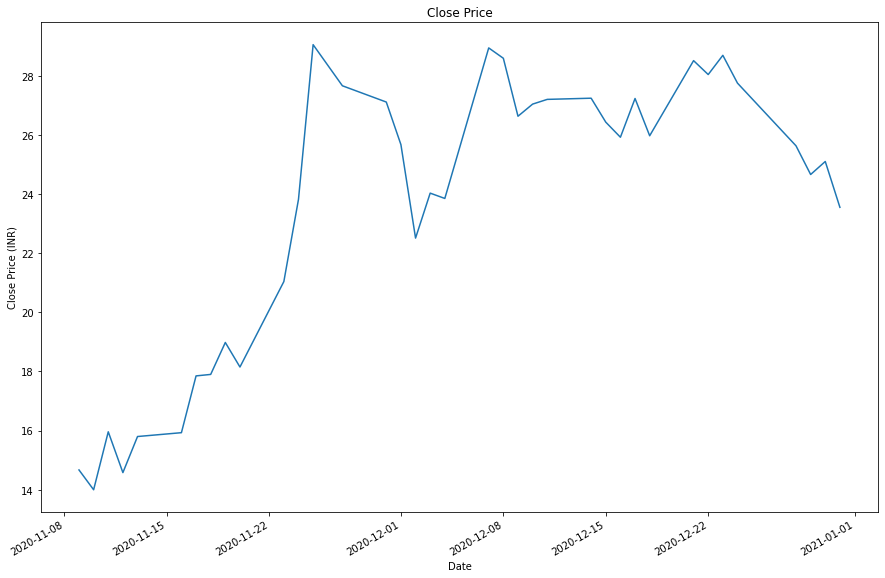

In [17]:
#stock data analysis
#Setting plot size and labels
plt.figure(figsize=(15,10))

stock_data['Close'].plot()


plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')

In [18]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2020-11-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-17,15.541429,-0.714414,0.132286,0.774714,0.092714,15.417143,16.398571,14.540000,7.162984e+07
2020-11-18,16.002857,-0.714429,0.134714,0.774857,0.090143,15.891429,16.877143,15.030000,7.589540e+07
2020-11-19,16.714286,-0.714371,0.132000,0.777714,0.090000,16.392857,17.444286,15.712857,7.848779e+07
2020-11-20,17.027143,-0.999686,0.134000,0.781857,0.083714,17.030000,17.971428,16.227143,8.207009e+07


<AxesSubplot:>

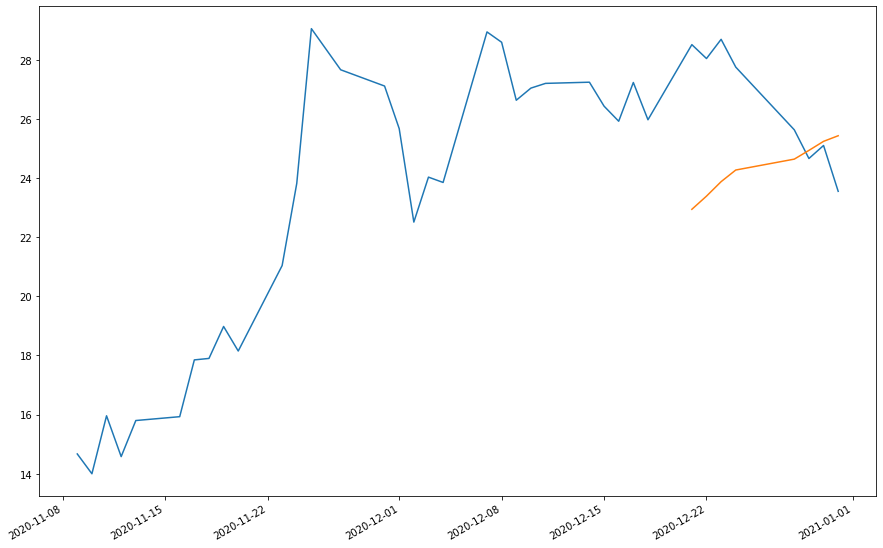

In [19]:
# setting figure size
plt.figure(figsize=(15,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [20]:

# displaying stock_data
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2020-11-09,14.670000,-0.9998,0.131,0.787,0.082,14.960000,15.900000,14.110000,60099000.0
2020-11-10,14.000000,-0.9998,0.126,0.800,0.074,14.990000,15.010000,13.180000,38078700.0
2020-11-11,15.960000,0.9974,0.116,0.758,0.127,14.570000,15.970000,14.400000,47027900.0
2020-11-12,14.580000,-0.9993,0.122,0.783,0.094,16.660000,17.059999,14.410000,97904000.0
2020-11-13,15.800000,-0.9997,0.135,0.771,0.094,14.490000,16.000000,14.490000,76354800.0
2020-11-16,15.930000,-0.9999,0.161,0.742,0.096,15.960000,16.100000,15.010000,65326000.0
2020-11-17,17.850000,-0.9998,0.135,0.782,0.082,16.290001,18.750000,16.180000,116618500.0
2020-11-18,17.900000,-0.9999,0.148,0.788,0.064,18.280001,19.250000,17.540001,89957900.0
2020-11-19,18.980000,-0.9994,0.107,0.820,0.073,18.500000,18.980000,17.959999,56225400.0
2020-11-20,18.150000,-0.9998,0.130,0.787,0.083,19.030001,19.660000,18.000000,72104000.0


In [21]:

# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 28
Number of records in Test Data: 9


In [22]:
# predicting one step ahead
steps_to_predict = 1


close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


2020-11-10    14.000000
2020-11-11    15.960000
2020-11-12    14.580000
2020-11-13    15.800000
2020-11-16    15.930000
2020-11-17    17.850000
2020-11-18    17.900000
2020-11-19    18.980000
2020-11-20    18.150000
2020-11-23    21.040001
2020-11-24    23.820000
2020-11-25    29.049999
2020-11-27    27.660000
2020-11-30    27.110001
2020-12-01    25.670000
2020-12-02    22.510000
2020-12-03    24.030001
2020-12-04    23.850000
2020-12-07    28.940001
2020-12-08    28.590000
2020-12-09    26.629999
2020-12-10    27.040001
2020-12-11    27.200001
2020-12-14    27.240000
2020-12-15    26.430000
2020-12-16    25.920000
2020-12-17    27.230000
2020-12-18    25.969999
2020-12-21    28.510000
2020-12-22    28.040001
2020-12-23    28.690001
2020-12-24    27.750000
2020-12-28    25.629999
2020-12-29    24.660000
2020-12-30    25.100000
2020-12-31    23.549999
Name: Close, dtype: float64

In [23]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
2020-11-10,14.000000,15.960000,-0.9998,0.9974,38078700.0,14.990000,15.010000,13.180000
2020-11-11,15.960000,14.580000,0.9974,-0.9993,47027900.0,14.570000,15.970000,14.400000
2020-11-12,14.580000,15.800000,-0.9993,-0.9997,97904000.0,16.660000,17.059999,14.410000
2020-11-13,15.800000,15.930000,-0.9997,-0.9999,76354800.0,14.490000,16.000000,14.490000
2020-11-16,15.930000,17.850000,-0.9999,-0.9998,65326000.0,15.960000,16.100000,15.010000
2020-11-17,17.850000,17.900000,-0.9998,-0.9999,116618500.0,16.290001,18.750000,16.180000
2020-11-18,17.900000,18.980000,-0.9999,-0.9994,89957900.0,18.280001,19.250000,17.540001
2020-11-19,18.980000,18.150000,-0.9994,-0.9998,56225400.0,18.500000,18.980000,17.959999
2020-11-20,18.150000,21.040001,-0.9998,-0.9983,72104000.0,19.030001,19.660000,18.000000
2020-11-23,21.040001,23.820000,-0.9983,-0.9996,84716300.0,18.629999,21.450001,18.570000


In [24]:
#close price shifted set as the target var
y = data['close_price_shifted']
y

2020-11-10    15.960000
2020-11-11    14.580000
2020-11-12    15.800000
2020-11-13    15.930000
2020-11-16    17.850000
2020-11-17    17.900000
2020-11-18    18.980000
2020-11-19    18.150000
2020-11-20    21.040001
2020-11-23    23.820000
2020-11-24    29.049999
2020-11-25    27.660000
2020-11-27    27.110001
2020-11-30    25.670000
2020-12-01    22.510000
2020-12-02    24.030001
2020-12-03    23.850000
2020-12-04    28.940001
2020-12-07    28.590000
2020-12-08    26.629999
2020-12-09    27.040001
2020-12-10    27.200001
2020-12-11    27.240000
2020-12-14    26.430000
2020-12-15    25.920000
2020-12-16    27.230000
2020-12-17    25.969999
2020-12-18    28.510000
2020-12-21    28.040001
2020-12-22    28.690001
2020-12-23    27.750000
2020-12-24    25.629999
2020-12-28    24.660000
2020-12-29    25.100000
2020-12-30    23.549999
Name: close_price_shifted, dtype: float64

In [25]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
2020-11-10,14.000000,-0.9998,0.9974,38078700.0,14.990000,15.010000,13.180000
2020-11-11,15.960000,0.9974,-0.9993,47027900.0,14.570000,15.970000,14.400000
2020-11-12,14.580000,-0.9993,-0.9997,97904000.0,16.660000,17.059999,14.410000
2020-11-13,15.800000,-0.9997,-0.9999,76354800.0,14.490000,16.000000,14.490000
2020-11-16,15.930000,-0.9999,-0.9998,65326000.0,15.960000,16.100000,15.010000
2020-11-17,17.850000,-0.9998,-0.9999,116618500.0,16.290001,18.750000,16.180000
2020-11-18,17.900000,-0.9999,-0.9994,89957900.0,18.280001,19.250000,17.540001
2020-11-19,18.980000,-0.9994,-0.9998,56225400.0,18.500000,18.980000,17.959999
2020-11-20,18.150000,-0.9998,-0.9983,72104000.0,19.030001,19.660000,18.000000
2020-11-23,21.040001,-0.9983,-0.9996,84716300.0,18.629999,21.450001,18.570000


In [26]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-1.        , -0.99989986,  1.        , -0.87030153, -0.94011976,
         -1.        , -1.        ],
        [-0.73953487,  1.        , -0.99939919, -0.77170253, -0.99041916,
         -0.89616009, -0.83591122],
        [-0.92292358, -0.99939919, -0.99979973, -0.21116835, -0.74011978,
         -0.77825863, -0.83456623],
        [-0.76079733, -0.99979973, -1.        , -0.44858952, -1.        ,
         -0.89291509, -0.82380631],
        [-0.74352158, -1.        , -0.99989986, -0.57010079, -0.82395211,
         -0.88209843, -0.75386683],
        [-0.48837206, -0.99989986, -1.        , -0.00497887, -0.78443103,
         -0.595457  , -0.596503  ],
        [-0.48172754, -1.        , -0.99949932, -0.29871556, -0.54610769,
         -0.54137372, -0.41358422],
        [-0.33820594, -0.99949932, -0.99989986, -0.67036786, -0.51976051,
         -0.57057869, -0.35709491],
        [-0.44850495, -0.99989986, -0.99839784, -0.49542328, -0.45628734,
         -0.49702542, -0.35171482],
        [-

In [27]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in Training set X: (28, 7) and y: (28, 1)
Number of rows and columns in Test set X: (6, 7) and y: (6, 1)


In [28]:
#reshaping dataset

print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (28, 7)
Shape of Test set X: (6, 7)


In [29]:
# seed set to achieve consistent and less random predictions
np.random.seed(2016)

# setting the architecture for the data model
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 7, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [30]:
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, batch_size=8, epochs=10, verbose=1)

Epoch 1/10
4/4 [==============================] - 6s 16ms/step - loss: 0.4782
Epoch 2/10
4/4 [==============================] - 0s 16ms/step - loss: 0.4454
Epoch 3/10
4/4 [==============================] - 0s 16ms/step - loss: 0.4141
Epoch 4/10
4/4 [==============================] - 0s 13ms/step - loss: 0.3682
Epoch 5/10
4/4 [==============================] - 0s 16ms/step - loss: 0.2879
Epoch 6/10
4/4 [==============================] - 0s 16ms/step - loss: 0.2006
Epoch 7/10
4/4 [==============================] - 0s 13ms/step - loss: 0.1832
Epoch 8/10
4/4 [==============================] - 0s 16ms/step - loss: 0.1842
Epoch 9/10
4/4 [==============================] - 0s 19ms/step - loss: 0.1527
Epoch 10/10
4/4 [==============================] - 0s 16ms/step - loss: 0.1600


In [33]:
Y_predict=model.predict(X_test)

In [34]:
from sklearn.metrics import r2_score #r2=1-(sum of resudual/sum of mean) #where sum of mean>sum of residual #so we will get a small value #therefore 1- small value
score=r2_score(y_test,Y_predict)  

In [35]:
score

0.538226362546881